# Statistical Modeling of Diffuse Solar Irradiance from Direct Irradience and Cloud Cover measurements

In [1]:
#IMPORTS
import pandas as pd
import os
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import pylab as py
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from joblib import dump, load

In [2]:
#Time for Polynomial Fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, median_absolute_error
from sklearn.preprocessing import power_transform

In [3]:
_Curr_Dir = os.getcwd()
_Testing_Data_Dir = os.path.join(_Curr_Dir, 'Testing_Data')

In [4]:
def logify_df(df):
    df['DHI_log'] = np.log(df['DHI'])
    df['GHI_log'] = np.log(df['GHI'])
    df['cloud_cover_log'] = np.log(df['Cloud Cover']+0.0000001)
    return df

In [5]:
def make_df_nonzero(df):
    df_no_zero = df.loc[df['DHI']!= 0 ]
    assert len(df_no_zero['DHI'])==len(df_no_zero['GHI']), "Some DHI 0s where GHI is not 0"
    print(df_no_zero)
    return df_no_zero 

In [6]:
def seasonize(df):
    seasons = []
    for month in df['Month']:
        if month in [12,1,2,3]:
            seasons.append('Winter')
        elif month in [4,5,6]:
            seasons.append('Spring')
        elif month in [7,8,9]:
            seasons.append('Summer')
        else:
            seasons.append('Fall')
    df['Season'] = pd.Series(seasons)
    return df
        

In [7]:
def meta_visualization(data, x='GHI', y='DHI', z='Cloud Cover'):
    sns.lmplot(x, y, data=data, hue=z, fit_reg=False)
    plt.show()
    return

In [8]:
def segment_visualization(data, x='GHI', y='DHI', z='Cloud Cover'):
    sns.lmplot(x, y, data=data, hue=z, row=z, fit_reg=True)
    plt.show()
    return

In [9]:
def featureHistograms(df, features=['GHI','DHI','Cloud Cover'],):
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(ncols=len(features))
    for i in range(len(features)):
        sns.distplot(df[features[i]], ax=axs[i])

In [10]:
def three_dee_viz(x,y,z,preds=[]):
    #3d viz
    fig = pyplot.figure()
    ax = Axes3D(fig)
    ax.set(xlabel='arg1', ylabel='arg2', zlabel='arg3')
    ax.scatter(x,y,z)
    if any(preds):
        ax.scatter(x, preds,z)
    plt.show()

In [11]:
def resids_viz(actuals, predictions):
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(ncols=2)
    residuals = actuals - predictions
    sm.qqplot(residuals, line='45', ax=axs[0])
    sns.regplot(x=predictions, y=residuals, ax=axs[1], label="Residual vs fitted")
    axs[1].set(xlabel='Fitted', ylabel='Residuals')


In [12]:
def make_OLS(X, Y):
    ols_model = LinearRegression().fit(X, Y)
    r2 = ols_model.score(X, Y)
    print("r2 is ", r2)
    return ols_model, r2

In [13]:
def show_model_metrics(X, Y, model):
    preds = model.predict(X)
    resids = Y - preds
    rmse = np.sqrt(mean_squared_error(Y,preds))
    r2 = r2_score(Y,preds)
    print("rmse is ", rmse)
    print("r2 is ",r2)
    print("mean absolute error is ",mean_absolute_error(Y,preds))
    print("mean squared log error is ", mean_squared_log_error(Y, preds))
    print("median absolute error is ", median_absolute_error(Y, preds))
    print("MAPE is ", np.mean(np.abs((Y - preds) / Y)) * 100)
    return preds, resids

In [14]:
def show_model_metrics_logBackTrans(X, Y, model):
    preds = model.predict(X)
    preds = np.exp(preds)
    resids = Y - preds
    rmse = np.sqrt(mean_squared_error(Y,preds))
    r2 = r2_score(Y,preds)
    print("******LOG BACK TRANSFORMED METRICS")
    print("rmse is ", rmse)
    print("r2 is ",r2)
    print("mean absolute error is ",mean_absolute_error(Y,preds))
    print("mean squared log error is ", mean_squared_log_error(Y, preds))
    print("median absolute error is ", median_absolute_error(Y, preds))
    print("MAPE is ", np.mean(np.abs((Y - preds) / Y)) * 100)
    return preds, resids

## South Dakota 2018 Data, aka the original data 

In [15]:
#Get 2018 Data
df1_2018 = pd.read_csv(os.path.join(_Testing_Data_Dir,'psm_south_dakota', 'psm_testing_data2018.csv'))

In [16]:
print(df1_2018)

      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
0     2018      1    1     0      30        -22.5             0             0   
1     2018      1    1     1      30        -23.1             0             0   
2     2018      1    1     2      30        -23.6             0             0   
3     2018      1    1     3      30        -23.9             0             0   
4     2018      1    1     4      30        -24.1             0             0   
...    ...    ...  ...   ...     ...          ...           ...           ...   
8755  2018     12   31    19      30        -12.8            60           892   
8756  2018     12   31    20      30        -13.0            52           859   
8757  2018     12   31    21      30        -13.6            41           770   
8758  2018     12   31    22      30        -14.6            26           537   
8759  2018     12   31    23      30        -15.1             0             0   

      Clearsky GHI  Cloud T

In [17]:
#Zeros are removed because it ends up recording hours of night time data
#We dont need to record when sunlight is 0
df1_2018 = make_df_nonzero(df1_2018)
logify_df(df1_2018)

      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
14    2018      1    1    14      30        -24.4            17           323   
15    2018      1    1    15      30        -22.4            37           762   
16    2018      1    1    16      30        -20.3            48           896   
17    2018      1    1    17      30        -18.5            54           955   
18    2018      1    1    18      30        -17.0            56           976   
...    ...    ...  ...   ...     ...          ...           ...           ...   
8754  2018     12   31    18      30        -12.9            65           889   
8755  2018     12   31    19      30        -12.8            60           892   
8756  2018     12   31    20      30        -13.0            52           859   
8757  2018     12   31    21      30        -13.6            41           770   
8758  2018     12   31    22      30        -14.6            26           537   

      Clearsky GHI  Cloud T

Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
14    2018      1    1    14      30        -24.4            17           323   
15    2018      1    1    15      30        -22.4            37           762   
16    2018      1    1    16      30        -20.3            48           896   
17    2018      1    1    17      30        -18.5            54           955   
18    2018      1    1    18      30        -17.0            56           976   
...    ...    ...  ...   ...     ...          ...           ...           ...   
8754  2018     12   31    18      30        -12.9            65           889   
8755  2018     12   31    19      30        -12.8            60           892   
8756  2018     12   31    20      30        -13.0            52           859   
8757  2018     12   31    21      30        -13.6            41           770   
8758  2018     12   31    22      30        -14.6            26           537   

      Clearsky GHI  Cloud Type  ...  Surface Albedo  Pressure  \
14              29           8  ...            0.69       978   
15             171           8  ...            0.69       978   
16             306           0  ...            0.69       978   
17             400           0  ...            0.69       977   
18             440           0  ...            0.69       976   
...            ...         ...  ...             ...       ...   
8754           414           4  ...            0.70       960   
8755           397           4  ...            0.70       961   
8756           327           4  ...            0.70       962   
8757           212           4  ...            0.70       963   
8758            75           7  ...            0.70       964   

      Precipitable Water  Wind Direction  Wind Speed  timestamps  Cloud Cover  \
14                   0.1             236         1.2  1514790000         0.44   
15                   0.1             216         1.2  1514793600         1.00   
16                   0.1             194         1.4  1514797200         0.75   
17                   0.1             174         1.6  1514800800         0.44   
18                   0.1             157         1.9  1514804400         0.19   
...                  ...             ...         ...         ...          ...   
8754                 0.6             356         8.5  1546254000         1.00   
8755                 0.6             355         8.4  1546257600         1.00   
8756                 0.5             353         8.2  1546261200         1.00   
8757                 0.4             352         7.6  1546264800         1.00   
8758                 0.4             350         6.8  1546268400         0.99   

       DHI_log   GHI_log  cloud_cover_log  
14    2.484907  2.639057    -8.209803e-01  
15    3.970292  4.663439     1.000000e-07  
16    4.094345  5.613128    -2.876819e-01  
17    4.158883  5.929589    -8.209803e-01  
18    4.025352  6.086775    -1.660731e+00  
...        ...       ...              ...  
8754  4.158883  5.945421     1.000000e-07  
8755  4.615121  5.755742     1.000000e-07  
8756  4.488636  5.549076     1.000000e-07  
8757  4.234107  5.036953     1.000000e-07  
8758  3.496508  3.912023    -1.005023e-02  

[4494 rows x 27 columns]

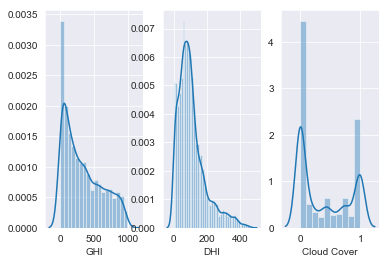

In [18]:
#Take a look at data distribution
featureHistograms(df1_2018)

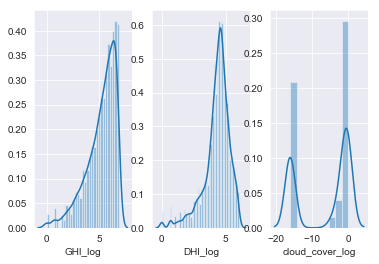

In [19]:
#Take a look at data distribution in logs
# sns.set_style('darkgrid')
# fig, axs = plt.subplots(ncols=3)
# sns.distplot(df1_2018['Cloud Cover'], ax=axs[0])
# sns.distplot(df1_2018['GHI_log'], ax=axs[1])
# sns.distplot(df1_2018['DHI_log'], ax=axs[2])

featureHistograms(df1_2018, ['GHI_log', 'DHI_log', 'cloud_cover_log'])

In [20]:
#Remember cloud cover log is missing many values becayse we added a small jitter

Assumptions of Linear Regression:

1.Linearity: The relationship between X and the mean of Y is linear.
    -IE tthe residuals should be normally distributed
2.Homoscedasticity: The variance of residual is the same for any value of X.
3.Independence: Observations are independent of each other.
4.Normality: For any fixed value of X, Y is normally distributed.


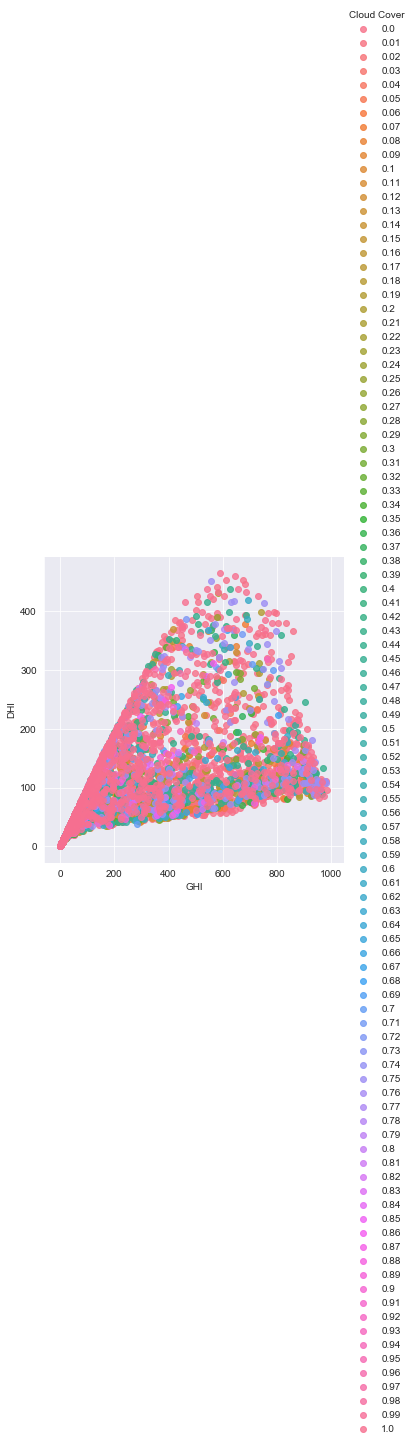

In [21]:
#See the overall data
meta_visualization(df1_2018, x='GHI', y='DHI', z='Cloud Cover')

In [22]:
#Heteroscedasticity is present. This is not good

## Polynomial fit with log transform of response 

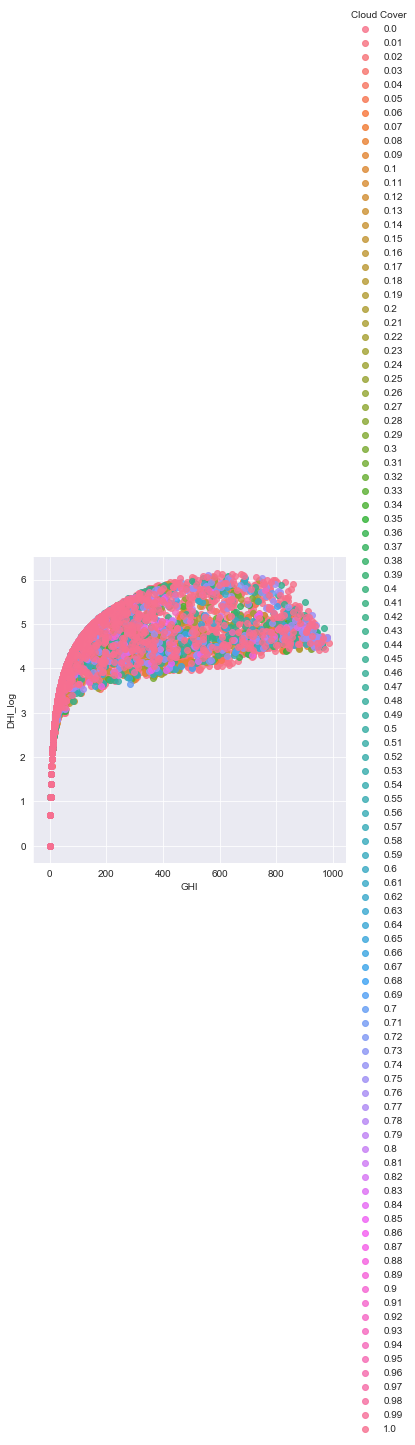

In [23]:
meta_visualization(df1_2018, x='GHI', y='DHI_log', z='Cloud Cover')

In [24]:
#Need to fit some poly stuff
#first create X feature vector of [GHI, Cloud Cover]
_GHI = df1_2018['GHI'].values
_Cloud_Cover = df1_2018['Cloud Cover'].values
_X = np.array(list(zip(_GHI, _Cloud_Cover)))

In [25]:
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(_X)
_DHI_log = df1_2018['DHI_log']

In [26]:
clf_poly = linear_model.LinearRegression()
clf_poly.fit(X_poly, _DHI_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [27]:
print(clf_poly.coef_)

[ 0.00000000e+00  4.10931067e-02  8.25022070e-02 -2.10323379e-04
  1.25931767e-04  3.23971458e-02  4.78464016e-07 -7.89474301e-06
  1.09172396e-02 -2.14491774e-04 -4.89035238e-10  1.21042036e-08
  1.45345267e-06 -1.90833226e-02 -2.21119292e-02  1.83560675e-13
 -7.60606215e-12  2.43441387e-09 -4.04026927e-06  1.11572334e-02
 -3.74068568e-02]


In [28]:
predictions_poly = show_model_metrics(X_poly, _DHI_log, clf_poly)[0]

rmse is  0.4991547780071287
r2 is  0.7568685086844883
mean absolute error is  0.39916258513543906
mean squared log error is  0.016365520068935553
median absolute error is  0.3436932169414999
MAPE is  inf


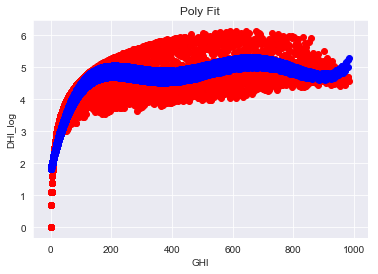

In [29]:
def viz_linear():
    plt.scatter(_GHI, _DHI_log, color='red')
    plt.scatter(_GHI, predictions_poly, color='blue')
#     plt.plot(_ghi_poly_sorted, preds_poly_sorted, 's', color='blue')
    plt.title('Poly Fit')
    plt.xlabel('GHI')
    plt.ylabel('DHI_log')
    plt.show()
    return
viz_linear()

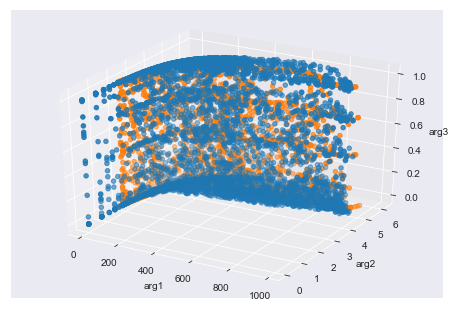

In [30]:
#3D visualizations
# fig = pyplot.figure()
# ax = Axes3D(fig)

# ax.scatter(df1_2018['GHI'], df1_2018['Cloud Cover'], df1_2018['DHI_log'])
# ax.scatter(df1_2018['GHI'], df1_2018['Cloud Cover'], predictions_poly)
# plt.show()
three_dee_viz(_GHI, _DHI_log, df1_2018['Cloud Cover'], predictions_poly )

In [31]:
#Baack transform
preds_back_transformed = np.exp(predictions_poly)
_DHI = df1_2018['DHI']
actuals = _DHI.values

print("mean absolute error is ",mean_absolute_error(actuals,preds_back_transformed))
print("mean squared log error is ", mean_squared_log_error(actuals, preds_back_transformed))
print("median absolute error is ", median_absolute_error(actuals, preds_back_transformed))
print("MAPE is ", np.mean(np.abs((actuals - preds_back_transformed) / actuals)) * 100)

mean absolute error is  43.22293248311914
mean squared log error is  0.22798687434195253
median absolute error is  26.284718752791132
MAPE is  44.6304804335543


In [32]:
#LEts see how our residuals hold up, lets see if we can wrangle this data

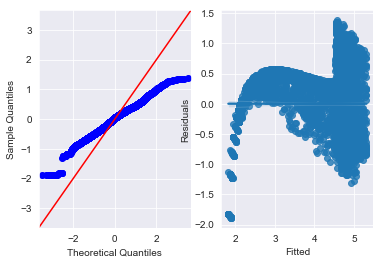

In [33]:
## QQplot and residuals vs. fitted
resids_viz(_DHI_log, predictions_poly)

In [34]:
#Residuals are not very normal, not great, not terrible
#model fit is pretty good

In [35]:
print(clf_poly)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [36]:
#This model is good, lets export it
dump(clf_poly, "Models/Polynomial_clf.joblib")

['Models/Polynomial_clf.joblib']


For polynomial regression models we assume that:

the behavior of a dependent variable y can be explained by a linear, or curvilinear, additive relationship between the dependent variable and a set of k independent variables (xi, i=1 to k)),
the relationship between the dependent variable y and any independent variable xi is linear or curvilinear (specifically polynomial),
the independent variables xi are independent of each other, and
the errors are independent, normally distributed with mean zero and a constant variance (OLS).


## Log- Log Transform Fitting

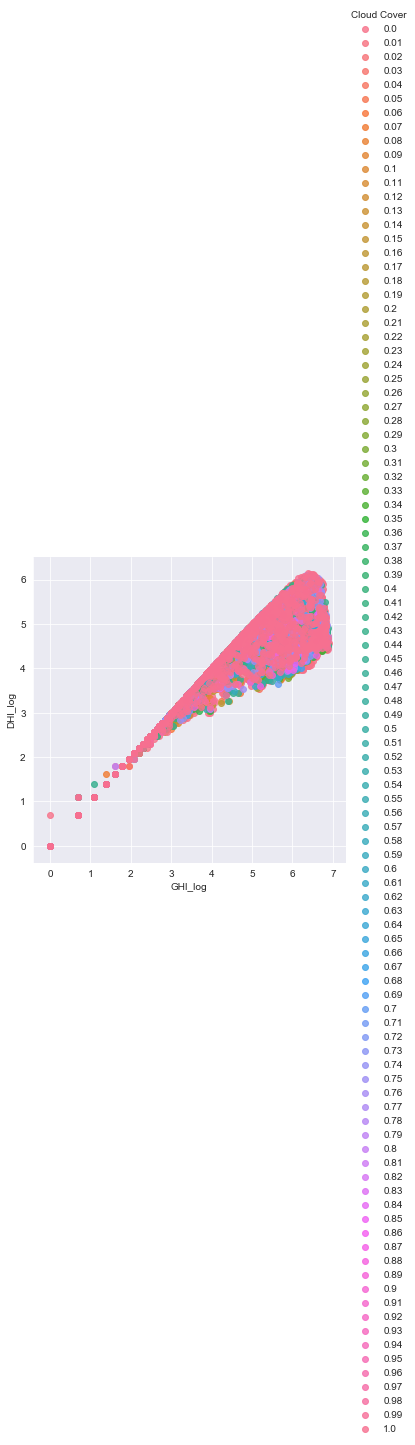

In [37]:
#See the overall data
meta_visualization(df1_2018, 'GHI_log', 'DHI_log', 'Cloud Cover')
# meta_visualization(df1_2018, 'GHI_log', 'DHI_log', 'cloud_cover_log')

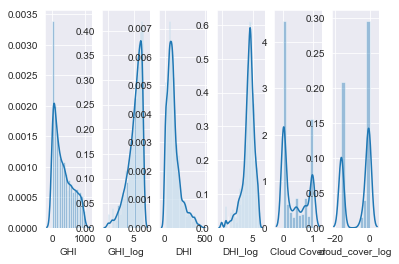

In [38]:
featureHistograms(df1_2018, ['GHI', 'GHI_log', 'DHI','DHI_log', 'Cloud Cover', 'cloud_cover_log'])

In [39]:
#cloud_cover_log data is too skewed. Lets just use regular cloud cover

In [40]:
#Fit the linear model
#first create X feature vector of [GHI, Cloud Cover]
_GHI_log = df1_2018['GHI_log'].values
_Cloud_Cover = df1_2018['Cloud Cover'].values
# _Cloud_Cover = df1_2018['cloud_cover_log'].values
_X_log = np.array(list(zip(_GHI_log, _Cloud_Cover)))
_DHI_log = df1_2018['DHI_log']

In [41]:
OLS_log_log = make_OLS(_X_log, _DHI_log)[0]

r2 is  0.744334589378747


In [42]:
OLS_log_log.coef_

array([0.62767233, 0.3428279 ])

In [43]:
OLS_log_log.intercept_

0.9351297431441159

In [44]:
#Predictions and metrics

In [45]:
predictions_log = show_model_metrics(_X_log, _DHI_log, OLS_log_log)[0]

rmse is  0.5118593177162724
r2 is  0.744334589378747
mean absolute error is  0.4313808973773106
mean squared log error is  0.012859520120319393
median absolute error is  0.41262900659752355
MAPE is  inf


In [46]:
#Back transform
preds_back_transformed_log = np.exp(predictions_log)
actuals = df1_2018['DHI']
print("mean absolute error is ",mean_absolute_error(actuals,preds_back_transformed_log))
print("mean squared log error is ", mean_squared_log_error(actuals, preds_back_transformed_log))
print("median absolute error is ", median_absolute_error(actuals, preds_back_transformed_log))
print("MAPE is ", np.mean(np.abs((actuals - preds_back_transformed_log) / actuals)) * 100)

mean absolute error is  49.61377521241005
mean squared log error is  0.24871151141706607
median absolute error is  34.92363593702837
MAPE is  45.74211866425743


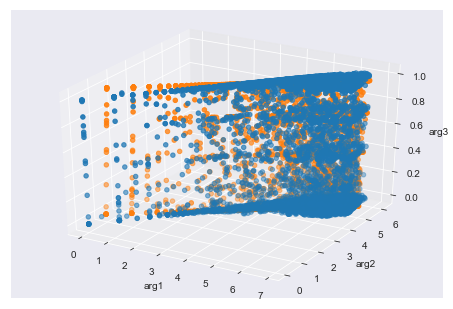

In [47]:
# #3d viz
three_dee_viz(df1_2018['GHI_log'], df1_2018['DHI_log'], df1_2018['Cloud Cover'], predictions_log)

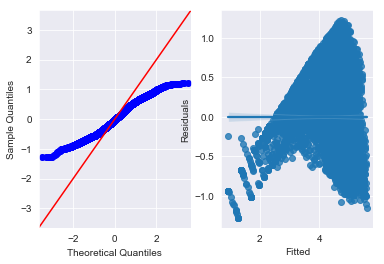

In [48]:
resids_viz(_DHI_log, predictions_log)

In [49]:
#Residual fit not bad not great

In [50]:
#CONCLUSION: Fit is pretty good

In [51]:
#Export
dump(OLS_log_log, "Models/OLS_log_log_clf.joblib")

['Models/OLS_log_log_clf.joblib']

## Power Transform 

In [52]:
box_cox_vector = list(zip(df1_2018['GHI'], df1_2018['Cloud Cover'], df1_2018['DHI']))
box_cox = power_transform(box_cox_vector, method='yeo-johnson')
box_cox_X = list([i[0] for i in box_cox])
box_cox_X2 = list([i[1] for i in box_cox])
box_cox_Y = list([i[2] for i in box_cox])
df1_2018['box_cox_GHI'] = pd.Series(box_cox_X)
df1_2018['box_cox_cloud_cover'] = pd.Series(box_cox_X2)
df1_2018['box_cox_DHI'] = pd.Series(box_cox_Y)


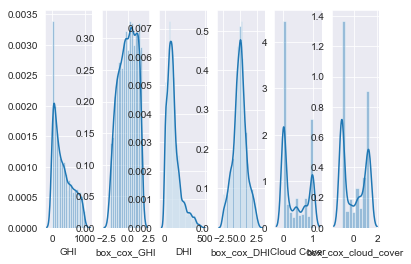

In [53]:
#Distribution of the features
featureHistograms(df1_2018, ['GHI','box_cox_GHI', 'DHI', 'box_cox_DHI', 'Cloud Cover', 'box_cox_cloud_cover'])

In [54]:
#Distributions are much more normal

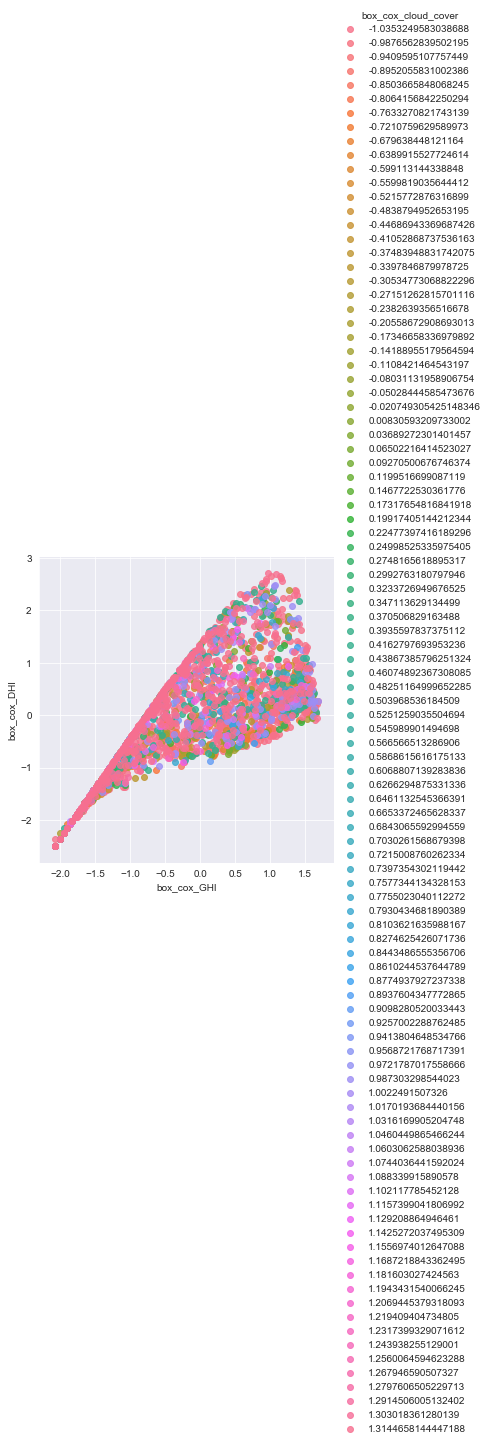

In [55]:
#See the overall data
meta_visualization(df1_2018,'box_cox_GHI', 'box_cox_DHI','box_cox_cloud_cover' )

In [56]:
#Still heteroskedastic, whatever, lets fit a curve

In [57]:
#Fit the linear model
# #first create X feature vector of [GHI, Cloud Cover]
_ptrans_X = np.array(list(zip(df1_2018['box_cox_GHI'].values, df1_2018['box_cox_cloud_cover'].values)))
ptrans_actuals = df1_2018['box_cox_DHI'].values

In [58]:
#There are alot of nan values and invalid values in this data
#Lets make a new df without these nans, and perform analytics on that

In [59]:
#Drop NA
df2018_yeojohnson_transform = df1_2018.dropna()
print(df2018_yeojohnson_transform)
#Redefine the vars
#Fit the linear model
#first create X feature vector of [GHI, Cloud Cover]
_df2_ptrans_X1 = df2018_yeojohnson_transform['box_cox_GHI'].values
_df2_ptrans_X2 = df2018_yeojohnson_transform['box_cox_cloud_cover'].values
_df2_ptrans_X = np.array(list(zip(_df2_ptrans_X1, _df2_ptrans_X2)))
_df2_ptrans_actuals = df2018_yeojohnson_transform['box_cox_DHI'].values

      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
14    2018      1    1    14      30        -24.4            17           323   
15    2018      1    1    15      30        -22.4            37           762   
16    2018      1    1    16      30        -20.3            48           896   
17    2018      1    1    17      30        -18.5            54           955   
18    2018      1    1    18      30        -17.0            56           976   
...    ...    ...  ...   ...     ...          ...           ...           ...   
4485  2018      7    6    21      30         31.4           133           790   
4486  2018      7    6    22      30         30.9           116           750   
4487  2018      7    6    23      30         30.5            98           675   
4488  2018      7    7     0      30         28.4            71           564   
4489  2018      7    7     1      30         26.5            40           340   

      Clearsky GHI  Cloud T

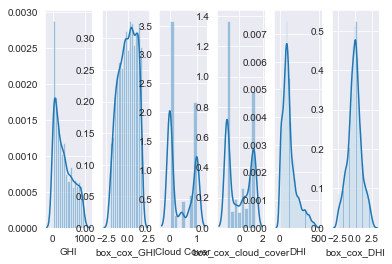

In [60]:
#Take a look at data distribution
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=6)
sns.distplot(df2018_yeojohnson_transform['GHI'], ax=axs[0])
sns.distplot(df2018_yeojohnson_transform['box_cox_GHI'], ax=axs[1])
sns.distplot(df2018_yeojohnson_transform['Cloud Cover'], ax=axs[2])
sns.distplot(df2018_yeojohnson_transform['box_cox_cloud_cover'], ax=axs[3])
sns.distplot(df2018_yeojohnson_transform['DHI'], ax=axs[4])
sns.distplot(df2018_yeojohnson_transform['box_cox_DHI'], ax=axs[5])

In [61]:
#Data Distribution still much better

In [62]:
df2018_ptransform_lin_reg = LinearRegression().fit(_df2_ptrans_X, _df2_ptrans_actuals)
df2018_ptransform_lin_reg.score(_df2_ptrans_X, _df2_ptrans_actuals)

0.5152314620121814

In [63]:
df2018_ptransform_lin_reg = LinearRegression().fit(_df2_ptrans_X, _df2_ptrans_actuals)


In [64]:
preds_ptrans = df2018_ptransform_lin_reg.predict(_df2_ptrans_X)

In [65]:
#BAAAAD score

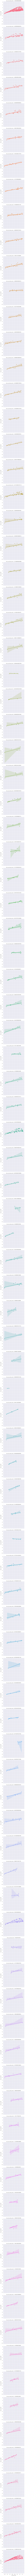

In [66]:
sns.lmplot('box_cox_GHI', 'box_cox_DHI', data=df2018_yeojohnson_transform, hue='box_cox_cloud_cover', row='box_cox_cloud_cover', fit_reg=True)
plt.show()

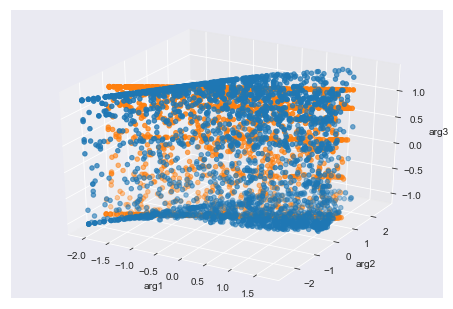

In [67]:
three_dee_viz(df2018_yeojohnson_transform['box_cox_GHI'], df2018_yeojohnson_transform['box_cox_DHI'], df2018_yeojohnson_transform['box_cox_cloud_cover'],preds_ptrans)

In [68]:
#But does not fix heteroskedasticity,
#Possibily because cloud cover data is so skewed

In [69]:
#I dont like this model because it involves dropping so much data

## Square root transformation 

In [70]:
#Lets take the square root of everything and see what happens.

In [71]:
df1_2018= pd.read_csv(os.path.join(_Testing_Data_Dir, 'psm_testing_data2018.csv'))
#Remove Zeros
df1_2018 = make_df_nonzero(df1_2018)
# df1_psm_2017['Cloud Cover'] = df1_psm_2017['Cloud Cover'].apply(lambda x: x+0.00001)
#Logify
df1_2018 = logify_df(df1_2018)
print(df1_2018['cloud_cover_log'])

      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
14    2018      1    1    14      30        -24.4            17           323   
15    2018      1    1    15      30        -22.4            37           762   
16    2018      1    1    16      30        -20.3            48           896   
17    2018      1    1    17      30        -18.5            54           955   
18    2018      1    1    18      30        -17.0            56           976   
...    ...    ...  ...   ...     ...          ...           ...           ...   
8754  2018     12   31    18      30        -12.9            65           889   
8755  2018     12   31    19      30        -12.8            60           892   
8756  2018     12   31    20      30        -13.0            52           859   
8757  2018     12   31    21      30        -13.6            41           770   
8758  2018     12   31    22      30        -14.6            26           537   

      Clearsky GHI  Cloud T

In [72]:
ghi_sqrt = np.sqrt(df1_2018['GHI'])
dhi_sqrt = np.sqrt(df1_2018['DHI'])
cc_sqrt = np.sqrt(df1_2018['Cloud Cover'])
df1_2018['ghi_sqrt'] = pd.Series(ghi_sqrt).dropna()
df1_2018['dhi_sqrt'] = pd.Series(dhi_sqrt).dropna()
df1_2018['cc_sqrt'] = pd.Series(cc_sqrt).dropna()

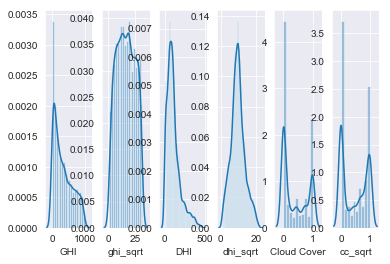

In [73]:
# #Take a look at data distribution
featureHistograms(df1_2018, ['GHI', 'ghi_sqrt', 'DHI', 'dhi_sqrt', 'Cloud Cover','cc_sqrt'])

In [74]:
#Data is much more normal, this is good

In [75]:
# print(df1_2018['dhi_sqrt'].dropna())

In [76]:
_X_sqrt = list(zip(df1_2018['ghi_sqrt'], df1_2018['cc_sqrt']))
df2018_sqrt_ft = make_OLS(_X_sqrt, df1_2018['dhi_sqrt'])[0]
print(df2018_sqrt_ft)

r2 is  0.44908614077505316
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [77]:
#oooooohhhh that's not good
dhi_sqrt_preds = show_model_metrics(_X_sqrt, df1_2018['dhi_sqrt'].values, df2018_sqrt_ft)[0]
dhi_sqrt_preds_2 = dhi_sqrt_preds*dhi_sqrt_preds

rmse is  2.9217933487276126
r2 is  0.44908614077505316
mean absolute error is  2.361639657906579
mean squared log error is  0.082158762510106
median absolute error is  2.0717014056599004
MAPE is  30.678643885731518


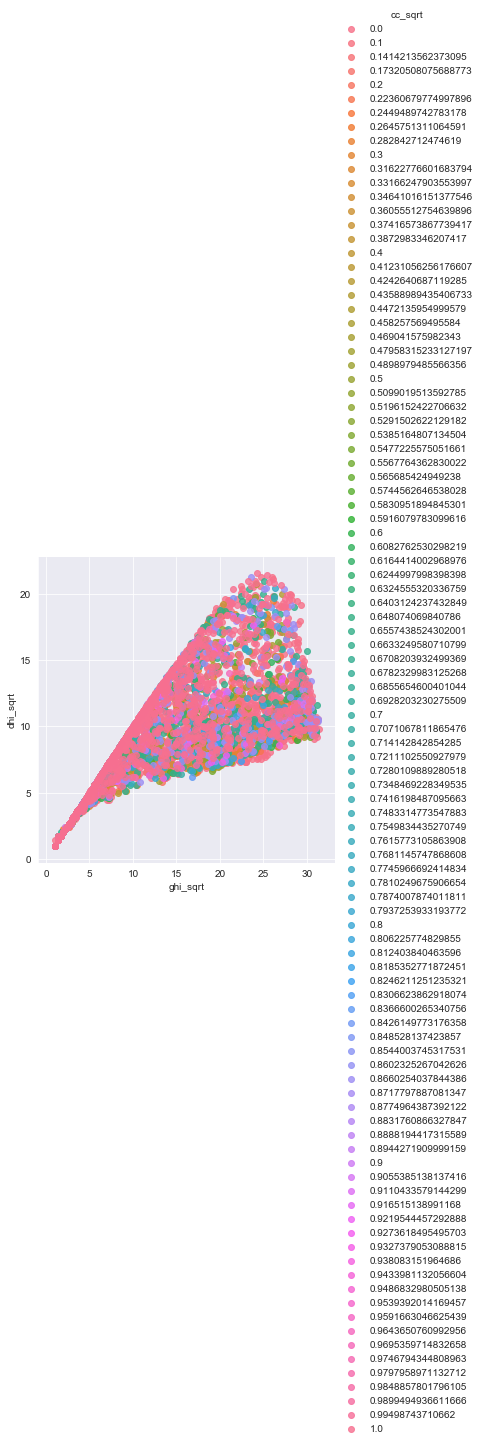

In [78]:
meta_visualization(df1_2018, x='ghi_sqrt', y='dhi_sqrt', z='cc_sqrt')

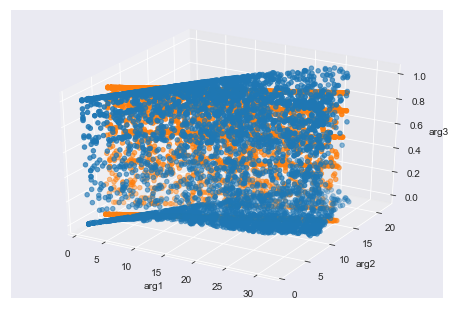

In [79]:
#3d
three_dee_viz(df1_2018['ghi_sqrt'], df1_2018['dhi_sqrt'].values, df1_2018['cc_sqrt'].values,dhi_sqrt_preds)

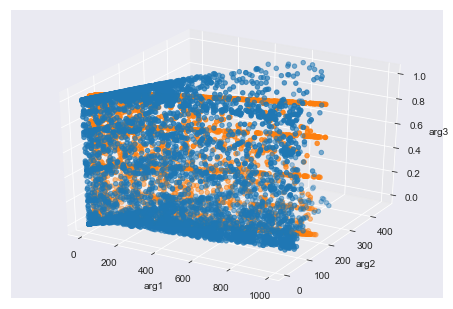

In [80]:
#Back transformed
three_dee_viz(df1_2018['GHI'], df1_2018['DHI'].values,df1_2018['Cloud Cover'].values, dhi_sqrt_preds_2)

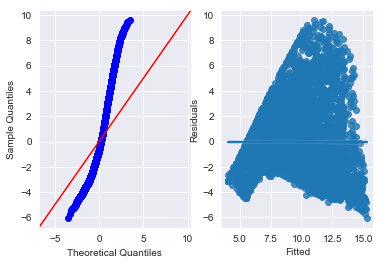

In [81]:
resids_viz(df1_2018['dhi_sqrt'].dropna().values, dhi_sqrt_preds)

In [82]:
#SAD!
#Also had to drop too many values

## Logit Transformation 

In [83]:
#try a logit transformation of cloud cover to bring in tails

In [84]:
from scipy.special import logit

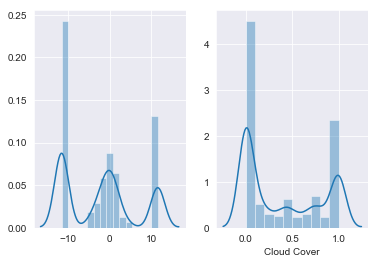

In [85]:
logit_vals = (df1_2018['Cloud Cover'].values)
for i in range(len(logit_vals)):
    if logit_vals[i] ==0:
        logit_vals[i]+=0.00001
    elif logit_vals[i]==1:
        logit_vals[i]-=0.00001
logit_vals = logit(logit_vals)


sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=2)
sns.distplot(logit_vals, ax=axs[0])
sns.distplot(df1_2018['Cloud Cover'], ax=axs[1])


In [86]:
#There are alot of NaN values, so we should go ahead and make a new df
#Our df1_2018 should be 'pristine'

In [87]:
df1_2018['logit_vals'] = pd.Series(logit_vals)
df_logit = df1_2018.dropna()
_X_logit = list(zip(df_logit['GHI_log'].values, df_logit['logit_vals'].values))

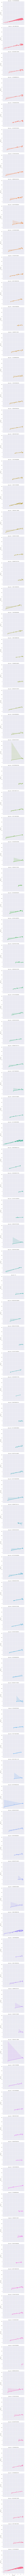

In [88]:
# sns.lmplot('GHI_log', 'DHI_log', data=df1_2018, hue='logt_vals', row='logt_vals', fit_reg=True)
# plt.show()
segment_visualization(df_logit, x='GHI_log', y='DHI_log', z='logit_vals')

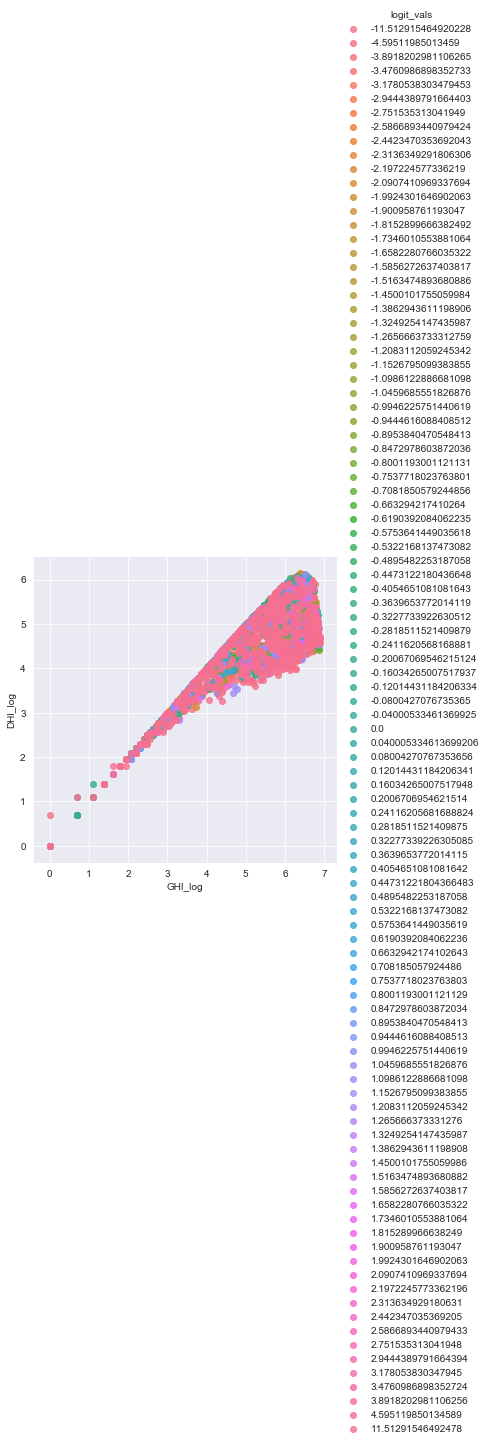

In [89]:
meta_visualization(df_logit, x='GHI_log', y='DHI_log', z='logit_vals')

In [90]:
model_logit_regression = make_OLS(_X_logit, df_logit['DHI_log'])[0]

r2 is  0.7267537323536782


In [91]:
preds_logit_log = show_model_metrics(_X_logit, df_logit['DHI_log'], model_logit_regression)[0]

rmse is  0.5273109259035009
r2 is  0.7267537323536782
mean absolute error is  0.4533495210509071
mean squared log error is  0.012370175714363977
median absolute error is  0.4595218421663323
MAPE is  inf


In [92]:
#Nice score but lots of data loss

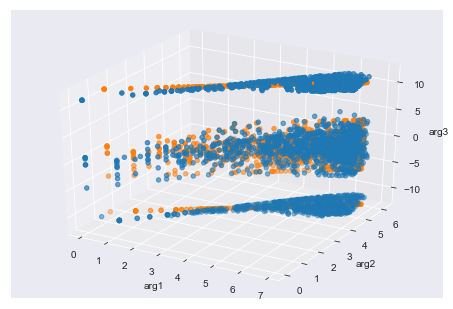

In [93]:
three_dee_viz(df_logit['GHI_log'],df_logit['DHI_log'],df_logit['logit_vals'],preds_logit_log)

In [94]:
preds_logit_log_backtrans = np.exp(preds_logit_log)
rmse = np.sqrt(mean_squared_error(df_logit['DHI'],preds_logit_log_backtrans))
r2 = r2_score(df_logit['DHI'],preds_logit_log_backtrans)
print("rmse is ", rmse)
print("r2 is ",r2)
print("mean absolute error is ",mean_absolute_error(df_logit['DHI'],preds_logit_log_backtrans))
print("mean squared log error is ", mean_squared_log_error(df_logit['DHI'], preds_logit_log_backtrans))
print("median absolute error is ", median_absolute_error(df_logit['DHI'], preds_logit_log_backtrans))
print("MAPE is ", np.mean(np.abs((df_logit['DHI'] - preds_logit_log_backtrans) / df_logit['DHI'])) * 100)

rmse is  79.12727846408266
r2 is  0.23342063866259455
mean absolute error is  56.658833287668045
mean squared log error is  0.265737557975607
median absolute error is  42.894922429739
MAPE is  47.676470869139045


In [95]:
#Similair to log log transformation

In [96]:
#no good. 

SUMMARY SO FAR
1.Best Models
    1. Polynomial fit on log transformed response 
        r2 is  0.7568685086844883
        mean absolute error is  0.39916258513543906
    2. OLS on log log transformed
        r2 is  0.744334589378747
        mean absolute error is  0.4313808973773106
    3. OLS on logit transformed cloud cover with log transformed feature and response
        r2 is 0.7423416730220415
        mean absolute error is  0.4333386346193195
    4. OLS power transformed for all variables
        r2 is 0.5152314620121814
    5. OLS on power transformation features and response with logit transformed cloud cover
        r2 is 0.5150425478934472
        


In [97]:
#Let's go a complete new direction. Let's try generalized least squares
#since variance in Y for each X is different linear estimaters like OLS wont work
#The big issue is the distribution of residuals

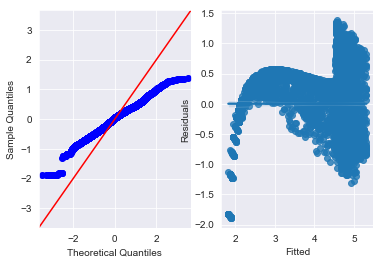

In [98]:
#Poly regression residuals
resids_viz(_DHI_log, predictions_poly)

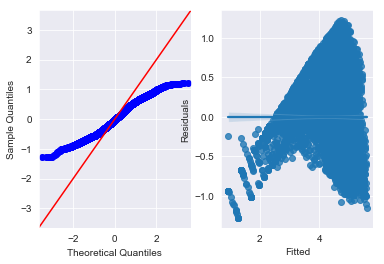

In [99]:
#Log-log regression resids
resids_viz(_DHI_log, predictions_log)

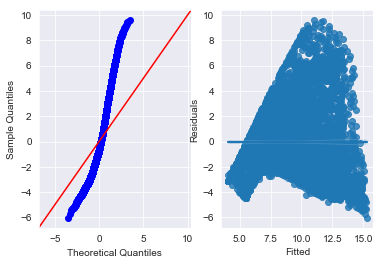

In [100]:
#sqrt regression resids
resids_viz(df1_2018['dhi_sqrt'].values, dhi_sqrt_preds)

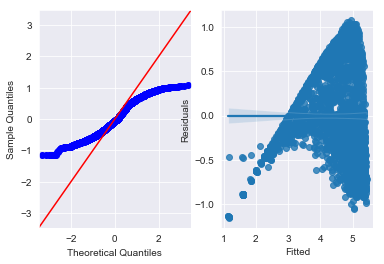

In [101]:
#Logit resids
resids_viz(df_logit['DHI_log'], preds_logit_log)

In [102]:
#GLS and WLS minimizes distance to residuals relative to covariance of those residuals

## Generalized Least Squares Regression

In [103]:
#Next approaches will use stats models instead of sklearn

In [104]:
#Use stats models on original data

exog = list(zip(df1_2018['GHI_log'].values, df1_2018['Cloud Cover'].values))
endog = df1_2018['DHI_log'].values
data_exog = sm.add_constant(exog)
ols_resid = sm.OLS(endog, exog).fit().resid

res_fit = sm.OLS(ols_resid[1:], ols_resid[:-1]).fit()
rho = res_fit.params
print(rho)

[0.77669571]


rho is a consistent estimator of the correlation of the
residuals from an OLS fit of the data. 
It is assumed that this is the true rho of the AR process data.


In [105]:
from scipy.linalg import toeplitz
order = toeplitz(np.arange(len(df1_2018)))
sigma = rho**order

In [106]:
#sigma is an n x n matrix of the autocorrelation structure of the data.

In [107]:
gls_model = sm.GLS(endog, exog, sigma=sigma)
gls_results = gls_model.fit()
print(gls_results.summary())

                                 GLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.925
Model:                            GLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                          2.761e+04
Date:                Tue, 22 Sep 2020   Prob (F-statistic):                        0.00
Time:                        23:02:45   Log-Likelihood:                         -1513.4
No. Observations:                4494   AIC:                                      3031.
Df Residuals:                    4492   BIC:                                      3044.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [108]:
preds_gls = gls_results.predict()

In [109]:
print("mean absolute error is ",mean_absolute_error(endog,preds_gls))
print("mean squared log error is ", mean_squared_log_error(endog, preds_gls))
print("median absolute error is ", median_absolute_error(endog, preds_gls))
# print("MAPE is ", np.mean(np.abs((endog - preds_gls) / endog)) * 100)

mean absolute error is  0.5319196004344574
mean squared log error is  0.01373809131139304
median absolute error is  0.529018318144785


In [110]:
#Backtransformed
preds_gls_backtrans = np.exp(preds_gls)
print("mean absolute error is ",mean_absolute_error(actuals,preds_gls_backtrans))
print("mean squared log error is ", mean_squared_log_error(actuals, preds_gls_backtrans))
print("median absolute error is ", median_absolute_error(actuals, preds_gls_backtrans))
print("MAPE is ", np.mean(np.abs((actuals - preds_gls_backtrans) / actuals)) * 100)


mean absolute error is  54.75931421200455
mean squared log error is  0.35596623865294025
median absolute error is  40.24565981478619
MAPE is  48.17234741449549


## GLS in Log-Log Model

In [111]:
#Use stats models on original data

exog = list(zip(df1_2018['GHI_log'].values, df1_2018['Cloud Cover'].values))
endog = df1_2018['DHI_log'].values
data_exog = sm.add_constant(exog)
ols_resid = sm.OLS(endog, exog).fit().resid

res_fit = sm.OLS(ols_resid[1:], ols_resid[:-1]).fit()
rho = res_fit.params

In [112]:
gls_model = sm.GLS(endog, exog)
gls_results = gls_model.fit()
print(gls_results.summary())

                                 GLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.984
Model:                            GLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          1.391e+05
Date:                Tue, 22 Sep 2020   Prob (F-statistic):                        0.00
Time:                        23:02:45   Log-Likelihood:                         -3770.7
No. Observations:                4494   AIC:                                      7545.
Df Residuals:                    4492   BIC:                                      7558.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [113]:
preds_gls = gls_results.predict()
residuals_gls = endog - preds_gls

In [114]:
print("mean absolute error is ",mean_absolute_error(endog,preds_gls))
print("mean squared log error is ", mean_squared_log_error(endog, preds_gls))
print("median absolute error is ", median_absolute_error(endog, preds_gls))
# print("MAPE is ", np.mean(np.abs((endog - preds_gls) / endog)) * 100)

mean absolute error is  0.4765762619369319
mean squared log error is  0.011372908735125708
median absolute error is  0.45139461077634824


In [115]:
#Predictions are off
#The line needs to fit! The data needs to be narrow

# Weighted Least Squares

In [116]:
#Step 1: Calculate Absolute Residuals from OLS model
#We are going to do this in the log log model

In [117]:
exog = list(zip(df1_2018['GHI_log'].values, df1_2018['Cloud Cover'].values))
ols_log_log_model = make_OLS(exog, df1_2018['DHI_log'])[0]
show_model_metrics(exog, df1_2018['DHI_log'], ols_log_log_model)
preds_ols_log_log = ols_log_log_model.predict(exog)
resids_ols_log_log = df1_2018['DHI_log'] - preds_ols_log_log
print(ols_log_log_model.intercept_, ols_log_log_model.coef_)

r2 is  0.7443346170501481
rmse is  0.5118592900162702
r2 is  0.7443346170501481
mean absolute error is  0.43138086752309474
mean squared log error is  0.012859519520409824
median absolute error is  0.4126300364874218
MAPE is  inf
0.9351268610792438 [0.62767234 0.34283353]


In [118]:
residuals_wls_abs = abs(resids_ols_log_log)

In [119]:
#Step 2. Get weights for WLS. 
#Step 2a. Fit OLS regression of absolute residuals vs. predictor (GHI_log)

In [120]:
ols_weight_maker = make_OLS(exog, residuals_wls_abs)[0]
print(ols_weight_maker)

r2 is  0.039338967949487436
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [121]:
#Step 2b. Use the predicted values of this model to calculate weights
weight_maker_fitted = ols_weight_maker.predict(exog)
print(weight_maker_fitted)
weights = 1/(weight_maker_fitted*weight_maker_fitted)
print(weights)

[0.33406886 0.43463057 0.46186645 ... 0.46909657 0.44916645 0.40499944]
[8.96041267 5.29370173 4.68777947 ... 4.54438876 4.95661713 6.09664832]


In [122]:
# Step 3 fit WLS using the sample weights
WLS_log_log = LinearRegression()
WLS_log_log.fit(exog, df1_2018['DHI_log'], sample_weight=weights)
show_model_metrics(exog, df1_2018['DHI_log'], WLS_log_log)
print(WLS_log_log.intercept_, WLS_log_log.coef_)

rmse is  0.5200305077514773
r2 is  0.7361066820817883
mean absolute error is  0.44040270466725395
mean squared log error is  0.010977149633961007
median absolute error is  0.4283542906493536
MAPE is  inf
0.6138223794565834 [0.69190748 0.32936905]


In [123]:
#Lets transform these to normal to see the real effects not deviations from geometric mean

In [124]:
WLS_preds_log = WLS_log_log.predict(exog)
WLS_preds = np.exp(WLS_preds_log)
actuals = df1_2018['DHI']
print("mean absolute error is ",mean_absolute_error(actuals,WLS_preds))
print("mean squared log error is ", mean_squared_log_error(actuals, WLS_preds))
print("median absolute error is ", median_absolute_error(actuals, WLS_preds))
print("MAPE is ", np.mean(np.abs((actuals - WLS_preds) / actuals)) * 100)

mean absolute error is  52.62387532080717
mean squared log error is  0.2611678084518856
median absolute error is  38.66258544757744
MAPE is  47.805762947694724


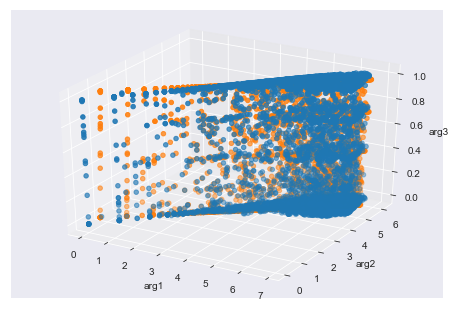

In [125]:
#3D visualization
three_dee_viz(df1_2018['GHI_log'], df1_2018['DHI_log'],df1_2018['Cloud Cover'], WLS_preds_log)

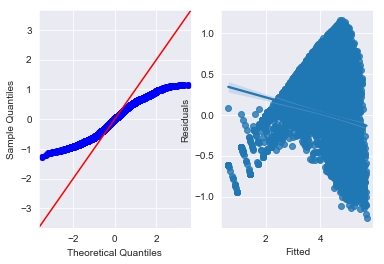

In [126]:
resids_viz(df1_2018['DHI_log'], WLS_preds_log)

In [127]:
#Sigh, export anyway

In [128]:
dump(WLS_log_log, "Models/Log_WLS_clf.joblib")

['Models/Log_WLS_clf.joblib']

## Does adding seasons, air pressure, and other variables change explanatory power?

In [129]:
#Lets try with seasons
df1_2018 = seasonize(df1_2018)
print(df1_2018['Season'])

14      Winter
15      Winter
16      Winter
17      Winter
18      Winter
         ...  
8754       NaN
8755       NaN
8756       NaN
8757       NaN
8758       NaN
Name: Season, Length: 4494, dtype: object


<class 'numpy.int64'>
<class 'str'>


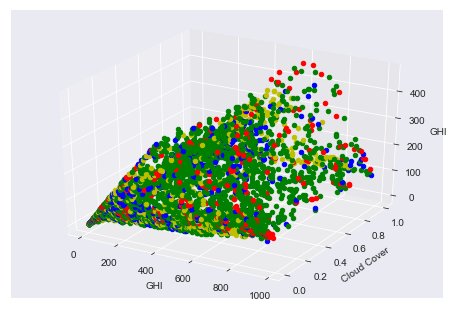

In [198]:
#See the data
colors = []
for i in df1_2018['Season']:
    if i == 'Fall':
        colors.append('r')
    elif i == 'Winter':
        colors.append('b')
    elif i == 'Spring':
        colors.append('y')
    else:
        colors.append('g')
ghi = df1_2018['GHI'].values
dhi = df1_2018['DHI'].values
cloud_cover = df1_2018['Cloud Cover'].values
s = df1_2018['Season'].values
print(type(ghi[9]))
print(type(s[9]))

fig = pyplot.figure()
ax = Axes3D(fig)

for i in range(len(ghi)):
    ax.scatter(ghi[i], cloud_cover[i], dhi[i], c=colors[i])
    

    
ax.set_xlabel('GHI', fontsize=10)
ax.set_ylabel('Cloud Cover', fontsize=10)
ax.set_zlabel('GHI', fontsize=10)
# ax.legend()
plt.show()
    



In [131]:
#Honestly, even with seasons, high variation across the board

In [132]:
#turn into dummy variables
dummies = pd.get_dummies(df1_2018['Season'], drop_first=True)
df1_2018 = df1_2018.join(dummies)
print(df1_2018.head())

    Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
14  2018      1    1    14      30        -24.4            17           323   
15  2018      1    1    15      30        -22.4            37           762   
16  2018      1    1    16      30        -20.3            48           896   
17  2018      1    1    17      30        -18.5            54           955   
18  2018      1    1    18      30        -17.0            56           976   

    Clearsky GHI  Cloud Type  ...   GHI_log  cloud_cover_log   ghi_sqrt  \
14            29           8  ...  2.639057    -8.209803e-01   3.741657   
15           171           8  ...  4.663439     1.000000e-07  10.295630   
16           306           0  ...  5.613128    -2.876819e-01  16.552945   
17           400           0  ...  5.929589    -8.209803e-01  19.390719   
18           440           0  ...  6.086775    -1.660731e+00  20.976177   

    dhi_sqrt   cc_sqrt  logit_vals  Season  Spring  Summer  Winter  
14  3

In [133]:
#Get values and perform linear regression

# fall = (df1_2018['Fall'].values)
winter = (df1_2018['Winter'].values)
spring = (df1_2018['Spring'].values)
summer = (df1_2018['Summer'].values)
print(winter)
print(type(winter[0]))

[1 1 1 ... 0 0 0]
<class 'numpy.uint8'>


In [134]:
X_4dim = list(zip(ghi, cloud_cover, winter, spring, summer))
dim4_regression = LinearRegression().fit(X_4dim, dhi)

In [135]:
model_4dim  = make_OLS(X_4dim, df1_2018['DHI'])[0]

r2 is  0.25367329327275834


In [136]:
show_model_metrics(X_4dim, dhi, model_4dim)

rmse is  72.42947145400956
r2 is  0.25367329327275834
mean absolute error is  54.472110748278254
mean squared log error is  0.6686972095385809
median absolute error is  42.97825166732074
MAPE is  158.07119089391182


(array([ 60.49801398,  89.67835167, 108.18179456, ..., 110.01631516,
         94.48280343,  78.52543247]),
 array([-48.49801398, -36.67835167, -48.18179456, ..., -21.01631516,
        -25.48280343, -45.52543247]))

In [137]:
#Bad. Lets see some p tests to see if weather changes things

In [138]:
#Screw this using statsmodels so muhc easier than sklearn
_X = sm.add_constant(X_4dim)
est = sm.OLS(dhi, _X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     305.1
Date:                Tue, 22 Sep 2020   Prob (F-statistic):          7.30e-282
Time:                        23:03:03   Log-Likelihood:                -25623.
No. Observations:                4494   AIC:                         5.126e+04
Df Residuals:                    4488   BIC:                         5.130e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.9260      2.311     19.005      0.0

In [139]:
#Weather doesnt seem to have explanatory power and has collinearity problems

### Out of curiosity, covariance + correlation matrices 

In [140]:
X_3dim = list(zip(ghi, cloud_cover, dhi))

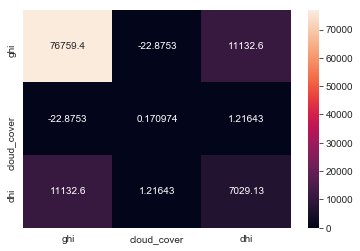

In [141]:
#Speaking of which, lets take a look at the covariance matrix
covMatrix = np.cov(X_3dim, rowvar=False, bias=True)
sns.heatmap(covMatrix, annot=True, fmt='g', xticklabels = ['ghi','cloud_cover','dhi'], yticklabels = ['ghi','cloud_cover','dhi'] )
plt.show()

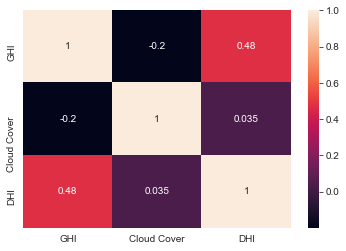

In [142]:
correlMatrix = df1_2018[['GHI', 'Cloud Cover', 'DHI', 'Season']].corr()
sns.heatmap(correlMatrix, annot=True)
plt.show()

In [143]:
#lets see if air pressure changes anything
#GHI and DHI are correlated

In [144]:
pressure = df1_2018['Pressure'].values
X_5dim = list(zip(ghi, cloud_cover, winter, spring, summer, pressure))


In [145]:
model_5dim  = make_OLS(X_5dim, dhi)[0]

r2 is  0.26242982924603275


In [146]:
#5 dim model with seasons and pressure added
show_model_metrics(X_5dim, dhi, model_5dim)

rmse is  72.00331586077696
r2 is  0.26242982924603275
mean absolute error is  53.87420918723734
mean squared log error is  0.663558176061189
median absolute error is  42.37393136699984
MAPE is  157.90245979308528


(array([ 35.17874305,  65.30690095,  83.358028  , ..., 101.07554098,
         84.40094608,  67.28549369]),
 array([-23.17874305, -12.30690095, -23.358028  , ..., -12.07554098,
        -15.40094608, -34.28549369]))

In [147]:
#Screw this using statsmodels so much easier than sklearn
_X = sm.add_constant(X_5dim)
est = sm.OLS(dhi, _X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     266.1
Date:                Tue, 22 Sep 2020   Prob (F-statistic):          4.54e-292
Time:                        23:03:03   Log-Likelihood:                -25596.
No. Observations:                4494   AIC:                         5.121e+04
Df Residuals:                    4487   BIC:                         5.125e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1144.8624    150.859      7.589      0.0

In [148]:
#That was not good
#Strong multicollinearity with season

In [149]:
#Maybe we have to log transform

In [150]:
#Lets do an OLS on log transformed values with possibly useful other valiues

In [151]:
#Model with log transformation, seasons, pressure
x_3dim2 = list(zip(df1_2018['GHI_log'].values, cloud_cover, winter, spring, summer, pressure))


In [152]:
model_3dim2  = make_OLS(x_3dim2, df1_2018['DHI_log'].values)[0]

r2 is  0.7510807637653116


In [153]:
show_model_metrics(x_3dim2,df1_2018['DHI_log'].values, model_3dim2 )

rmse is  0.5050610246958042
r2 is  0.7510807637653116
mean absolute error is  0.424156553873682
mean squared log error is  0.01274055743463198
median absolute error is  0.4034689093205235
MAPE is  inf


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


(array([2.49421384, 3.96548611, 4.47112895, ..., 4.65266089, 4.32019086,
        3.59977678]),
 array([-0.00930719,  0.0048058 , -0.37678439, ..., -0.16402452,
        -0.08608435, -0.10326922]))

In [154]:
_X = sm.add_constant(x_3dim2)
est = sm.OLS(df1_2018['DHI_log'], _X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                DHI_log   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     2256.
Date:                Tue, 22 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:03:03   Log-Likelihood:                -3307.0
No. Observations:                4494   AIC:                             6628.
Df Residuals:                    4487   BIC:                             6673.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6539      1.058     11.013      0.0

In [155]:
#Evidence for multicollinearity amongst seasons, air pressure seems to help a bit

In [156]:
#Lets see if removing seasons helps

In [157]:
#Log transforming GHI and DHI DEFINETLY helps

In [158]:
X_4dim = list(zip(df1_2018['GHI_log'], cloud_cover, pressure))
_X = sm.add_constant(X_4dim)
est = sm.OLS(df1_2018['DHI_log'], _X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                DHI_log   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     4489.
Date:                Tue, 22 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:03:03   Log-Likelihood:                -3317.1
No. Observations:                4494   AIC:                             6642.
Df Residuals:                    4490   BIC:                             6668.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4969      1.051     10.935      0.0

In [159]:
model_4dim = make_OLS(X_4dim, df1_2018['DHI_log'])[0]

r2 is  0.7499590947811634


In [160]:
show_model_metrics(X_4dim, df1_2018['DHI_log'], model_4dim)

rmse is  0.5061976875986672
r2 is  0.7499590947811634
mean absolute error is  0.4248698572595555
mean squared log error is  0.012739319623906417
median absolute error is  0.40100141632745423
MAPE is  inf


(array([2.47430624, 3.94848178, 4.45477169, ..., 4.68220972, 4.34938916,
        3.62796815]),
 14      0.010600
 15      0.021810
 16     -0.360427
 17     -0.393755
 18     -0.546772
           ...   
 8754   -0.794493
 8755   -0.208009
 8756   -0.193573
 8757   -0.115283
 8758   -0.131461
 Name: DHI_log, Length: 4494, dtype: float64)

In [161]:
#To be honest, it doesn't seem like air pressure helps a whole lot

In [162]:
#Lets see what the data looks like

<class 'numpy.int64'>
<class 'str'>


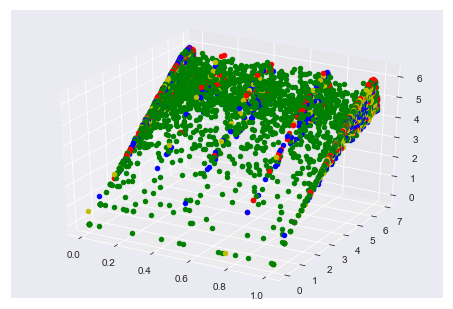

In [163]:
#Visualize with seasons
colors = []
for i in df1_2018['Season']:
    if i == 'Fall':
        colors.append('r')
    elif i == 'Winter':
        colors.append('b')
    elif i == 'Spring':
        colors.append('y')
    else:
        colors.append('g')
ghi_log = df1_2018['GHI_log'].values
dhi_log = df1_2018['DHI_log'].values
cloud_cover = df1_2018['Cloud Cover'].values
s = df1_2018['Season'].values
print(type(ghi[9]))
print(type(s[9]))

fig = pyplot.figure()
ax = Axes3D(fig)

for i in range(len(ghi)):
    ax.scatter(cloud_cover[i], ghi_log[i],  dhi_log[i], c=colors[i])
plt.show()
    


In [164]:
#Probably too much variation again. Model still has alot of variation
#But now with the colors you can see the depth of the model
#One reason why the seasons are so screwed up is because  the summer months
#Have such sspread, there are no readings in between 0.2,0.44,.74 that arent summer

In [165]:
#for some reason only summer months are represented betwween the main sensor bars

In [166]:
#Lots of variation

<class 'numpy.int64'>
<class 'str'>


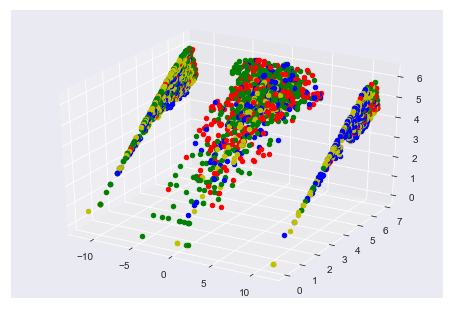

In [167]:
#Visualize with seasons, Logit
colors = []
for i in df1_2018['Season']:
    if i == 'Fall':
        colors.append('r')
    elif i == 'Winter':
        colors.append('b')
    elif i == 'Spring':
        colors.append('y')
    else:
        colors.append('g')
ghi_log = df1_2018['GHI_log'].values
dhi_log = df1_2018['DHI_log'].values
cloud_cover = df1_2018['Cloud Cover'].values
cloud_cover_logit = df1_2018['logit_vals'].values
s = df1_2018['Season'].values
print(type(ghi[9]))
print(type(s[9]))
fig = pyplot.figure()
ax = Axes3D(fig)

for i in range(len(ghi)):
    ax.scatter(cloud_cover_logit[i], ghi_log[i],  dhi_log[i], c=colors[i])
plt.show()
    

In [168]:
#This helps with middle values. Honestly, I may have to just bucket the cloud cover values

In [169]:
X_3dim = list(zip(df1_2018['GHI_log'], cloud_cover_logit, pressure))

In [170]:
# _X = sm.add_constant(X_2dim)
# est = sm.OLS(df1_2018['DHI_log'], X_3dim)
# est2 = est.fit()
# print(est2.summary())

In [171]:
#Bucketing probably wont work

In [172]:
#We need to squeeze these points together

In [173]:
#Data still two tailed

<class 'numpy.int64'>
<class 'str'>


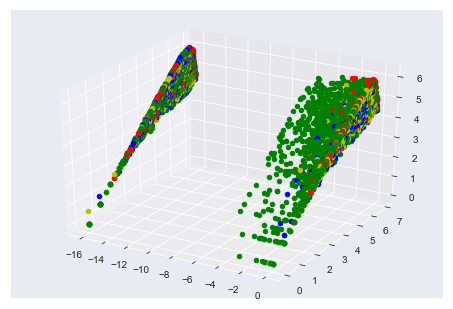

In [174]:
#Visualize with seasons
colors = []
for i in df1_2018['Season']:
    if i == 'Fall':
        colors.append('r')
    elif i == 'Winter':
        colors.append('b')
    elif i == 'Spring':
        colors.append('y')
    else:
        colors.append('g')
ghi_log = df1_2018['GHI_log'].values
dhi_log = df1_2018['DHI_log'].values
cloud_cover = df1_2018['Cloud Cover'].values
cloud_cover_log = df1_2018['cloud_cover_log'].values
s = df1_2018['Season'].values
print(type(ghi[9]))
print(type(s[9]))

fig = pyplot.figure()
ax = Axes3D(fig)

for i in range(len(ghi)):
    ax.scatter(cloud_cover_log[i], ghi_log[i],  dhi_log[i], c=colors[i])
plt.show()
    

## Poly Fit on Log Log model

In [175]:
print(df1_2018)

      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
14    2018      1    1    14      30        -24.4            17           323   
15    2018      1    1    15      30        -22.4            37           762   
16    2018      1    1    16      30        -20.3            48           896   
17    2018      1    1    17      30        -18.5            54           955   
18    2018      1    1    18      30        -17.0            56           976   
...    ...    ...  ...   ...     ...          ...           ...           ...   
8754  2018     12   31    18      30        -12.9            65           889   
8755  2018     12   31    19      30        -12.8            60           892   
8756  2018     12   31    20      30        -13.0            52           859   
8757  2018     12   31    21      30        -13.6            41           770   
8758  2018     12   31    22      30        -14.6            26           537   

      Clearsky GHI  Cloud T

In [176]:
#Need to fit some poly stuff
#first create X feature vector of [GHI, Cloud Cover]
_GHI = df1_2018['GHI_log'].values
_Cloud_Cover = df1_2018['cloud_cover_log'].values
_X = np.array(list(zip(_GHI, _Cloud_Cover)))

log_poly = PolynomialFeatures(degree=5)
log_X_poly = log_poly.fit_transform(_X)
log_actuals = df1_2018['DHI_log']

log_clf_poly = linear_model.LinearRegression()
log_clf_poly.fit(log_X_poly, log_actuals)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [177]:
Y = log_actuals
preds = log_clf_poly.predict(log_X_poly)
resids = log_actuals - preds
rmse = np.sqrt(mean_squared_error(Y,preds))
r2 = r2_score(Y,preds)
print("rmse is ", rmse)
print("r2 is ",r2)
print("mean absolute error is ",mean_absolute_error(Y,preds))
# print("mean squared log error is ", mean_squared_log_error(Y, preds))
print("median absolute error is ", median_absolute_error(Y, preds))
print("MAPE is ", np.mean(np.abs((Y - preds) / Y)) * 100)


rmse is  0.43753840428243285
r2 is  0.8131887158190436
mean absolute error is  0.3417830059492416
median absolute error is  0.279476752870949
MAPE is  inf


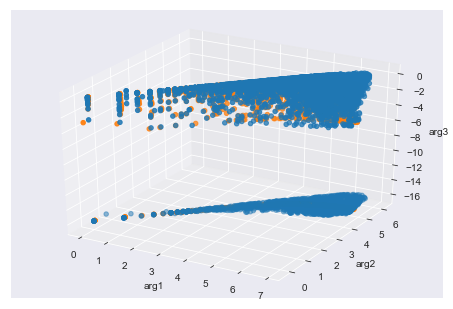

In [178]:
three_dee_viz(df1_2018['GHI_log'],df1_2018['DHI_log'],df1_2018['cloud_cover_log'],preds)

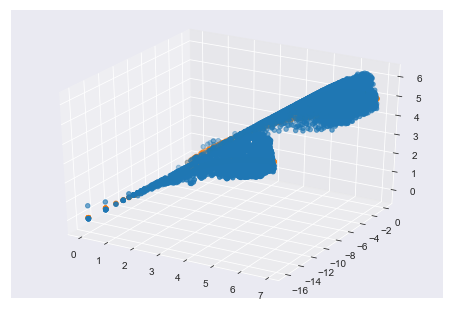

In [179]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(df1_2018['GHI_log'], df1_2018['cloud_cover_log'],df1_2018['DHI_log'])
ax.scatter(df1_2018['GHI_log'],df1_2018['cloud_cover_log'], preds)
plt.show()

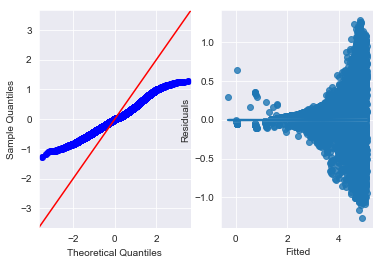

In [180]:
resids_viz(_DHI_log, preds)

In [181]:
#This may be a better fit

In [182]:
#back transformed
Y = df1_2018['DHI'].values
preds = np.exp(log_clf_poly.predict(log_X_poly))
resids = df1_2018['DHI'] - preds
rmse = np.sqrt(mean_squared_error(Y,preds))
r2 = r2_score(Y,preds)
print("rmse is ", rmse)
print("r2 is ",r2)
print("mean absolute error is ",mean_absolute_error(Y,preds))
print("mean squared log error is ", mean_squared_log_error(Y, preds))
print("median absolute error is ", median_absolute_error(Y, preds))
print("MAPE is ", np.mean(np.abs((Y - preds) / Y)) * 100)


rmse is  66.86928332708926
r2 is  0.3638614888066968
mean absolute error is  42.33848932814547
mean squared log error is  0.1876217365438958
median absolute error is  27.279531597433603
MAPE is  35.675543096814295


In [183]:
#And by slight margin, we have a winner

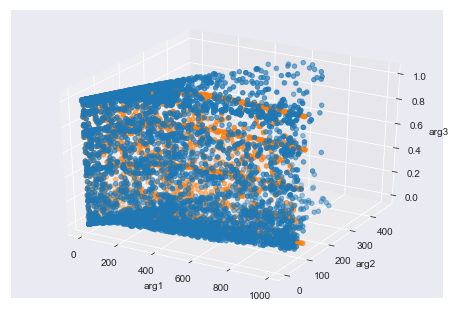

In [184]:
three_dee_viz(df1_2018['GHI'],df1_2018['DHI'],df1_2018['Cloud Cover'],preds)

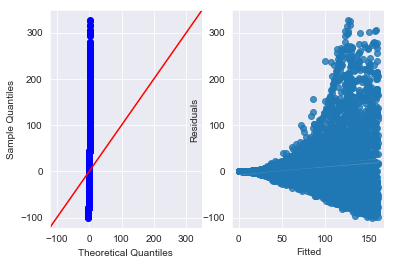

In [185]:
resids_viz(df1_2018['DHI'], preds)

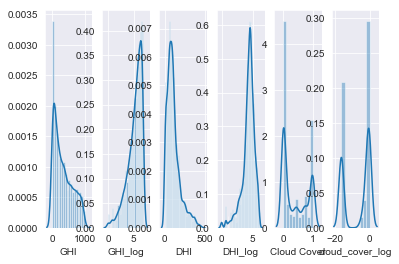

In [186]:
featureHistograms(df1_2018, ['GHI', 'GHI_log', 'DHI', 'DHI_log', 'Cloud Cover', 'cloud_cover_log'])

In [187]:
#Export the model
dump(log_clf_poly, "Models/Log_Log_Polynomial_clf.joblib")

['Models/Log_Log_Polynomial_clf.joblib']

### With normal cloud cover

In [188]:
#Need to fit some poly stuff
#first create X feature vector of [GHI, Cloud Cover]
_GHI = df1_2018['GHI_log'].values
_Cloud_Cover = df1_2018['Cloud Cover'].values
_X = np.array(list(zip(_GHI, _Cloud_Cover)))

log_poly = PolynomialFeatures(degree=5)
log_X_poly = log_poly.fit_transform(_X)
log_actuals = df1_2018['DHI_log']

log_clf_poly_2 = linear_model.LinearRegression()
log_clf_poly_2.fit(log_X_poly, log_actuals)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [189]:
Y = log_actuals
preds = log_clf_poly_2.predict(log_X_poly)
resids = log_actuals - preds
rmse = np.sqrt(mean_squared_error(Y,preds))
r2 = r2_score(Y,preds)
print("rmse is ", rmse)
print("r2 is ",r2)
print("mean absolute error is ",mean_absolute_error(Y,preds))
# print("mean squared log error is ", mean_squared_log_error(Y, preds))
print("median absolute error is ", median_absolute_error(Y, preds))
print("MAPE is ", np.mean(np.abs((Y - preds) / Y)) * 100)


rmse is  0.4371696292089475
r2 is  0.8135034873324514
mean absolute error is  0.3414690244608601
median absolute error is  0.2800318901427654
MAPE is  inf


In [190]:
dump(log_clf_poly_2, "Models/Log_Polynomial_clf.joblib")

['Models/Log_Polynomial_clf.joblib']

SUMMARY SO FAR
1.Best Models
    1. Polynomial on log log log
        rmse is  0.43753840428243285
        r2 is  0.8131887158190436
        mean absolute error is  0.3417830059492416
        median absolute error is  0.279476752870949
        MAPE is  inf
    1a. Polynomial on log log except cloud cover
        rmse is  0.4371696292089475
        r2 is  0.8135034873324514
        mean absolute error is  0.3414690244608601
        median absolute error is  0.2800318901427654
        MAPE is  inf
    2. Polynomial fit on log transformed response
        rmse is  0.4991547780071287
        r2 is  0.7568685086844883
        mean absolute error is  0.39916258513543906
        mean squared log error is  0.016365520068935553
        median absolute error is  0.3436932169414999
        MAPE is  inf
    3. OLS on log log transformed
        rmse is  0.5118593177162724
        r2 is  0.744334589378747
        mean absolute error is  0.4313808973773106
        mean squared log error is  0.012859520120319393
        median absolute error is  0.41262900659752355
        MAPE is  inf
    4. WLS on log log
        rmse is  0.5200305077514773
        r2 is  0.7361066820817883
        mean absolute error is  0.44040270466725395
        mean squared log error is  0.010977149633961007
        median absolute error is  0.4283542906493536
        MAPE is  inf
    5. Logit
        rmse is  0.5273109259035009
        r2 is  0.7267537323536782
        mean absolute error is  0.4533495210509071
        mean squared log error is  0.012370175714363977
        median absolute error is  0.4595218421663323
        MAPE is  inf
        